In [1]:
import os
import pandas as pd
import scipy.sparse as sci
import statsmodels.formula.api as smf
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import block_diag
from numpy.linalg import inv
from linearmodels.iv import IVGMM
from linearmodels.iv import IV2SLS
import numpy.linalg as lin
import matplotlib.pyplot as plt
import math
import scipy.optimize

In [19]:
os.chdir('/Users/agcolo/Dropbox/PhDCourses_Zurich/Second_year/Empirical_IO/Problem Set Agent Dynamics')

In [20]:
df = pd.read_stata('PS2_Data.dta')

In [318]:
# Replicate table 1

table_1_mean= df.groupby('age').aggregate(Age = ('age', np.mean) , School = ('SchD', np.mean), White_collar = ('WhCoD', np.mean), Blue_collar = ('BlCoD', np.mean))
table_1_sum = df.groupby('age').aggregate(Age = ('age', np.mean) , School = ('SchD', np.sum), White_collar = ('WhCoD', np.sum), Blue_collar = ('BlCoD', np.sum))

In [376]:
table_1 = pd.DataFrame(columns=[ 'Age', 'School', 'White_collar', 'Blue_collar'])

for i in range(1,11):
    table_1.loc[2*i] = round(table_1_mean.loc[i,],2)
    table_1.loc[2*i + 1] = table_1_sum.loc[i,].astype(int)

In [378]:
table_1

# We see that schooling is decreasing in age while White Collar and Blue Collar are increasing in age

,Age,School,White_collar,Blue_collar
2,1.0,0.44,0.27,0.29
3,1.0,221.00,133.00,146.00
4,2.0,0.40,0.28,0.32
5,2.0,199.00,142.00,159.00
6,3.0,0.37,0.33,0.30
7,3.0,185.00,165.00,150.00
8,4.0,0.33,0.36,0.32
9,4.0,164.00,178.00,158.00
10,5.0,0.30,0.35,0.35
11,5.0,149.00,177.00,174.00


In [22]:
# Replicate table 2

df['LagChoiceSchD'] = df.groupby('indiv')['SchD'].shift(1)
df['LagChoiceWhCod'] = df.groupby('indiv')['WhCoD'].shift(1)
df['LagChoiceBlCod'] = df.groupby('indiv')['BlCoD'].shift(1)

In [389]:
# Table 2

# First figure : percentage in each occupation who goes to each destination

def table2_1(current , previous):
    prop = df.loc[(current == 1) & (previous == 1),].shape[0] / df.loc[(previous == 1),].shape[0] 

    return prop

# Second figure : percentage in each occupation who started from each origin

def table2_2(current, previous):
    prop = df.loc[(current == 1) & (previous == 1),].shape[0] / df.loc[(current == 1) & (df.age !=1),].shape[0] 

    return prop


In [418]:
table_2 = []
for i in [df.LagChoiceSchD, df.LagChoiceWhCod, df.LagChoiceBlCod]:
    row = []
    row2 = []
    for j in [df.SchD, df.WhCoD, df.BlCoD]: 
        row.append(round(table2_1(j,i),3))
        row2.append(round(table2_2(j,i),3))
    table_2.append(row)
    table_2.append(row2)

In [419]:
table_2_df = pd.DataFrame(table_2)

table_2_df.columns = ['School', 'White Collar', 'Blue Collar']

list = ['School', 'School', 'White Collar', 'White Collar', 'Blue Collar', 'Blue Collar']

table_2_df['X'] = list

cols = table_2_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
table_2_df = table_2_df[cols]


In [420]:
table_2_df # For (i,j) i is state today and j is state yesterday. 
# First row is as % of origin, Second row is as % of destination

,X,School,White Collar,Blue Collar
0,School,0.250,0.375,0.375
1,School,0.282,0.306,0.306
2,White Collar,0.274,0.412,0.314
3,White Collar,0.357,0.389,0.296
4,Blue Collar,0.270,0.316,0.413
5,Blue Collar,0.361,0.305,0.398


+ We see high persistence in WC and BC occupations. Less persistence in schooling. There is a flow from BC to WC and also from WC to BC
  
+ We see that the % of people in school who stay in school is lower than the % of people currently in school who were in school last year. Thus, more likely to transition out of school than into school

+ With WC occupations the opposite occurs: The % of people in WC who stay in WC is 40% while the % of people who are in WC today and come from WC is 38%. More transitions into WC than out of 

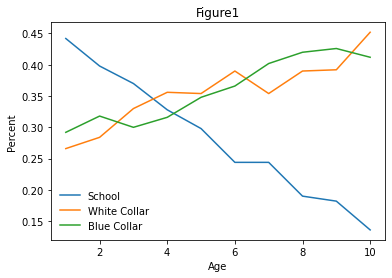

In [323]:
# Figure 1 should be created with table_1 dataframe
fig, ax = plt.subplots()

ax.plot(table_1_mean['Age'], table_1_mean['School'])
ax.plot(table_1_mean['Age'], table_1_mean['White_collar'])
ax.plot(table_1_mean['Age'], table_1_mean['Blue_collar'])

ax.set_title('Figure1')
ax.set_xlabel('Age', fontsize = 10)
ax.set_ylabel('Percent', fontsize = 10)


ax.legend(['School', 'White Collar', 'Blue Collar'], frameon = False)

As expected, proportion of people in school is decreasing in age, while WC and BC work are increasing in age. Note that for WC the increase is steeper for higher ages than for BC. This is probably because people coming out of school at higher ages are well educated and go more frequently to WC jobs than to BC jobs

## Solving single agent dynamic problem

In [33]:
Nind = 500

In [23]:
# Schooling years and work experience

df['g_a'] = df.groupby('indiv').transform('cumsum')['SchD'] + 10
df['x_w'] = df.groupby('indiv').transform('cumsum')['WhCoD'] 
df['x_b'] = df.groupby('indiv').transform('cumsum')['BlCoD'] 

In [24]:
# Correction to lag years of schooling

df['g_a'] = df['g_a'] - 1*(df['SchD'] == 1)
df['x_w'] = df['x_w'] - 1*(df['WhCoD'] == 1)
df['x_b'] = df['x_b'] - 1*(df['BlCoD'] == 1)

## Reward functions

$ R_s(a) = β_0 + β_1I[g(a) ≥ 12] + εs(a) $

In [25]:
def Rs(params_s, g_a):
    Beta0 , Beta1 = params_s
    Rs = Beta0 + Beta1*(g_a>11) 
    
    return Rs 

$ R_w(a) = α_1g(a) + α_2x_w(a) + α_3x^2_w(a) + ε_w(a) $

In [26]:
def Rw(params_w, g_a, x_w):
    alpha1, alpha2, alpha3 = params_w
    Rw = alpha1*g_a + alpha2*x_w + alpha3*x_w**2 

    return Rw

$ R_b(a) = η_1g(a) + η_2x_b(a) + η_3x^2_b (a) + ε_b(a) $

In [27]:
def Rb(params_b, g_a, x_b):
    eta1, eta2, eta3 = params_b
    Rb = eta1*g_a + eta2*x_b + eta3*x_b**2 

    return Rb

In [28]:
# Define parameters
Beta0_init = 0
Beta1_init = 0
Beta_init = np.array([Beta0_init, Beta1_init])
alpha1_init = 0.1
alpha2_init = 0.1
alpha3_init = -0.01
alpha_init = np.array([alpha1_init, alpha2_init, alpha3_init])
eta1_init = 0.1
eta2_init = 0.1
eta3_init = -0.01
Eta_init = np.array([eta1_init, eta2_init, eta3_init])
g_a_init = 10
γ = 0.57721566490153286061 # euler mascharoni constant. Mean of extreme value type 1

## Value functions

For a < A:
$$ 

V_k(S(a), a) = R_k(S(a), a) + δE[V (S(a + 1), a + 1)|S(a), d_k(a) = 1] 

 $$


For last age:
$$ 

V_k(S(A), A) = R_k(S(A), A)

 $$

Due to Gumbel distribution assumption we have:

$$
EMax = E(V(s)) = \gamma + ln(\sum_k (e^{V_k}))
$$

The state space consists of all factors, known to the individual, that affect current rewards or the probability distribution of any of the future rewards.

In [12]:
# Calculate EMax at age A

def EMax_A(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) # Nind * 1. One value for each individual
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) 
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b) 

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1


In [13]:
# EMax at age A-1

def EMax_A_1(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] #  Nind * 1
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1

In [14]:
# EMax at age A-2

def EMax_A_2(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_1(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0]
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_1(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_1(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1

In [15]:
# EMax at age A-3

def EMax_A_3(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_2(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] 
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_2(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_2(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1

In [16]:
# Period A-4

def EMax_A_4(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_3(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] 
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_3(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_3(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1

In [17]:
# Period A-5

def EMax_A_5(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_4(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] 
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_4(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_4(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1

In [18]:
# Period A-6

def EMax_A_6(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_5(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] 
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_5(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_5(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1

In [19]:
# Period A-7

def EMax_A_7(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_6(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] 
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_6(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_6(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1

In [20]:
# Period A-8

def EMax_A_8(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_7(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] 
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_7(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_7(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1


In [21]:
# Period A-9 (First period) This is the decision made at A-9 

def V_A_9(g_a, x_b, x_w, params_s, params_w, params_b):

    # Chooses schooling
    Vs = Rs(params_s, g_a) + 0.95*EMax_A_8(g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] 
    # Chooses white collar
    Vw = Rw(params_w, g_a, x_w) + 0.95*EMax_A_8(g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
    # Chooses blue collar
    Vb = Rb(params_b, g_a, x_b ) + 0.95*EMax_A_8(g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

    EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

    return [EMax, Vs, Vw, Vb]  # Nind X 1


## Trying in another way

In [39]:
value_functions = []

for i in range(10):
    def value_f(g_a, x_b, x_w, params_s, params_w, params_b, i = i):  # <- right here is the important bit

        if i == 0:
            Vs = Rs(params_s, g_a)
            Vw = Rw(params_w, g_a, x_w)
            Vb = Rb(params_b, g_a, x_b )
            
        else:
            # Chooses schooling
            Vs = Rs(params_s, g_a) + 0.95*value_functions[i-1](g_a + 1 , x_b, x_w, params_s, params_w, params_b)[0] #  Nind * 1
            # Chooses white collar
            Vw = Rw(params_w, g_a, x_w) + 0.95*value_functions[i-1](g_a , x_b, x_w + 1, params_s, params_w, params_b)[0]
            # Chooses blue collar
            Vb = Rb(params_b, g_a, x_b ) + 0.95*value_functions[i-1](g_a , x_b + 1 , x_w, params_s, params_w, params_b)[0]

        EMax = γ + np.log(np.sum(np.exp([Vs, Vw, Vb]), axis = 0))

        return [EMax, Vs, Vw, Vb]  # Nind X 1

    value_functions.append(value_f)

In [40]:
# Likelihood function 

def LL(params, df = df): 
    
    Beta0, Beta1, alpha1, alpha2, alpha3, eta1, eta2, eta3 = params

    Beta= np.array([Beta0, Beta1])
    alpha = np.array([alpha1, alpha2, alpha3])
    Eta = np.array([eta1,eta2,eta3])

    ll = 0

    for i in range(10):

        ga = np.array(df.loc[df.age == 10 - i,'g_a']).reshape(1,Nind)
        xb = np.array(df.loc[df.age == 10 - i,'x_b']).reshape(1,Nind)
        xw = np.array(df.loc[df.age == 10 - i,'x_w']).reshape(1,Nind)

        # numerator
        Num = np.array(np.concatenate(value_functions[i](ga, xb , xw , Beta, alpha, Eta )[1:4])).T # Nind * 3
        # denominator
        Denom = np.array(np.concatenate(value_functions[i](ga, xb , xw , Beta, alpha, Eta )[1:4])).T # Nind * 3
        # probabiility of decision at age a for each individual (Nind x 1)
        p_a = np.exp(np.sum(np.multiply(df.loc[df.age == 10 - i, ('SchD', 'WhCoD', 'BlCoD')], Num), axis = 1))  / np.sum(np.exp(Denom), axis = 1) 
        
        ll += np.sum(np.log(p_a))

    # print([Beta, alpha, Eta])

    ll = -1*ll

    print(ll)

    return ll



In [41]:
my_start = np.array([ 3.27244091, -1.4607128 ,  0.13444809,  0.90571256, -0.12215245,  0.1371122 ,  0.82266058, -0.10270789])

In [42]:
LL(my_start)

5182.792221455039


5182.792221455039

## Likelihood Function

Due to gumbel assumption we have a Logit Model 

$$
P(shock_i>shock_{j \neq i}) = \frac{e^{V_i}}{\sum_j(e^{V_j})}
$$


For each individual n:

$$

ll_n =  \prod_a p(d_a | X)  

$$
$$

log(ll_n) = \sum_a log(p_a | X)

$$

For the whole sample:
$$
LL = \sum_n log(ll_n)
$$

In [22]:
# Likelihood function 

def LL(params, df = df): 
    
    Beta0, Beta1, alpha1, alpha2, alpha3, eta1, eta2, eta3 = params

    Beta= np.array([Beta0, Beta1])
    alpha = np.array([alpha1, alpha2, alpha3])
    Eta = np.array([eta1,eta2,eta3])

    ll = 0

    functions = [EMax_A, EMax_A_1 , EMax_A_2, EMax_A_3, EMax_A_4, EMax_A_5, EMax_A_6, EMax_A_7, EMax_A_8, V_A_9]

    for i in range(len(functions)):

        ga = np.array(df.loc[df.age == 10 - i,'g_a']).reshape(1,Nind)
        xb = np.array(df.loc[df.age == 10 - i,'x_b']).reshape(1,Nind)
        xw = np.array(df.loc[df.age == 10 - i,'x_w']).reshape(1,Nind)

        # numerator
        Num = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha, Eta )[1:4])).T # Nind * 3
        # denominator
        Denom = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha, Eta )[1:4])).T # Nind * 3
        # probabiility of decision at age a for each individual (Nind x 1)
        p_a = np.exp(np.sum(np.multiply(df.loc[df.age == 10 - i, ('SchD', 'WhCoD', 'BlCoD')], Num), axis = 1))  / np.sum(np.exp(Denom), axis = 1) 
        
        ll += np.sum(np.log(p_a))

    # print([Beta, alpha, Eta])

    ll = -1*ll

    print(ll)

    return ll



In [43]:
my_start = np.array([Beta0_init, Beta1_init, alpha1_init, alpha2_init, alpha3_init, eta1_init, eta2_init, eta3_init])

In [44]:
otherargs = df

In [ ]:
MLE = minimize(LL,
                my_start,
                args = (otherargs),
                method = 'BFGS')

In [46]:
MLE.x

array([ 3.27276463, -1.46094566,  0.1344742 ,  0.90564124, -0.12214061,
        0.13712111,  0.82280685, -0.10273386])

In [139]:
MLE

      fun: 5182.792221454186
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02282832,  0.03083187, -0.07366907,  0.018008  ,  0.02373781,
       -0.26684575, -0.04029062,  0.01346052])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 756
      nit: 77
     njev: 84
   status: 0
  success: True
        x: array([ 3.27244091, -1.4607128 ,  0.13444809,  0.90571256, -0.12215245,
        0.1371122 ,  0.82266058, -0.10270789])

In [47]:
# standard errors: (not sure this is correct)
results = []
for i in range(8):
    Coef = round(MLE.x[i],3)
    SE = round(MLE.hess_inv[i,i]**0.5,3)
    res = [Coef, SE]
    results.append(res)

parameters = ["β_0", "β_1", "α_1", "α_2", "α_3", "η_1", "η_2", "η_3"]

results = pd.DataFrame(results, parameters)


results.columns = ['Coefficient', 'SE']
    

In [39]:
results

,Coefficient,SE
β_0,3.273,0.344
β_1,-1.461,0.176
α_1,0.134,0.028
α_2,0.906,0.157
α_3,-0.122,0.026
η_1,0.137,0.022
η_2,0.823,0.218
η_3,-0.103,0.034


Comments:
+ Positive returns to schooling for both occupations. Also very positive returns to experience in each occupation type, although returns are decreasing (concave) in experience
+ Schooling tuition costs seem to be quite high

## Unobserved heterogeneity 

For each individual n:

$$

ll_n = 0.5 *  \prod_a p(d_a | X, type 1) + 0.5  * \prod_a p(d_a | X, type 2) 

$$


For the whole sample:
$$
LL = \sum_n log(ll_n)
$$

In [40]:
# Likelihood function 

def LL_uh(params, df): # definir los argumentos
    
    Beta0, Beta1, alpha1_v1, alpha1_v2, alpha2, alpha3, eta1_v1, eta1_v2, eta2, eta3 = params

    Beta= np.array([Beta0, Beta1])
    alpha_v1 = np.array([alpha1_v1, alpha2, alpha3])
    Eta_v1 = np.array([eta1_v1,eta2,eta3])
    alpha_v2 = np.array([alpha1_v2, alpha2, alpha3])
    Eta_v2 = np.array([eta1_v2,eta2,eta3])

    ll_t1 = np.ones(500)
    ll_t2 = np.ones(500)

    functions = [EMax_A, EMax_A_1 , EMax_A_2, EMax_A_3, EMax_A_4, EMax_A_5, EMax_A_6, EMax_A_7, EMax_A_8, V_A_9]

    for i in range(len(functions)):

        ga = np.array(df.loc[df.age == 10 - i,'g_a']).reshape(1,Nind)
        xb = np.array(df.loc[df.age == 10 - i,'x_b']).reshape(1,Nind)
        xw = np.array(df.loc[df.age == 10 - i,'x_w']).reshape(1,Nind)

        # Type 1
        Num = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v1, Eta_v1 )[1:4])).T # Nind * 3
        Denom = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v1, Eta_v1 )[1:4])).T # Nind * 3
        # probabiility of decision at age a
        p_a_v1 = np.exp(np.sum(np.multiply(df.loc[df.age == 10 - i, ('SchD', 'WhCoD', 'BlCoD')], Num), axis = 1))  / np.sum(np.exp(Denom), axis = 1) # Nind X 1 --> prob that chosen option had the highest value for the individual

        # Type 2
        Num_v2 = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v2, Eta_v2 )[1:4])).T # Nind * 3
        Denom_v2 = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v2, Eta_v2 )[1:4])).T # Nind * 3
        # probabiility of decision at age a
        p_a_v2 = np.exp(np.sum(np.multiply(df.loc[df.age == 10 - i, ('SchD', 'WhCoD', 'BlCoD')], Num_v2), axis = 1))  / np.sum(np.exp(Denom_v2), axis = 1) # Nind X 1 --> prob that chosen option had the highest value for the individual

        ll_t1 = np.multiply(ll_t1.reshape(500,1), np.array(p_a_v1).reshape(500,1)) # Add log-likelihood contribution of age a to each individual (500 x 1)
        ll_t2 = np.multiply(ll_t2.reshape(500,1), np.array(p_a_v2).reshape(500,1))

    ll_i = 0.5 * ll_t1 + 0.5 * ll_t2 # this is a vector of 500*1 with loglikelihood contribution of individual i

    ll = np.sum(np.log(ll_i)) # we sum the log of all the items in this vector

    # print([Beta, alpha_v1, alpha_v2, Eta_v1, Eta_v2])

    ll = -1*ll

    print(ll)

    return ll



In [42]:
my_start2 = np.array([Beta0_init, Beta1_init, alpha1_init, alpha1_init + 0.1 ,  alpha2_init, alpha3_init, eta1_init, eta1_init - 0.1, eta2_init, eta3_init])

In [ ]:
MLE_uh = minimize(LL_uh,
                my_start2,
                args = (otherargs),
                method = 'BFGS')

In [46]:
MLE_uh.x

array([ 2.02057288, -1.13406402,  0.09341885,  0.21740695,  0.46498311,
       -0.11069236,  0.20563309,  0.10229992,  0.31734901, -0.07235602])

In [50]:
# standard errors: 
results = []
for i in range(10):
    Coef = round(MLE_uh.x[i],3)
    SE = MLE_uh.hess_inv[i,i]**0.5
    res = [Coef, SE]
    results.append(res)

parameters = ["β_0", "β_1", "α1_type1" ,"α1_type2" , "α_2", "α_3", "η1_type1", "η1_type2", "η_2", "η_3"]

results = pd.DataFrame(results, parameters)


results.columns = ['Coefficient', 'SE']

In [51]:
results

,Coefficient,SE
β_0,2.021,0.158649
β_1,-1.134,0.088670
α1_type1,0.093,0.016932
α1_type2,0.217,0.025399
α_2,0.465,0.123387
α_3,-0.111,0.021708
η1_type1,0.206,0.021107
η1_type2,0.102,0.010729
η_2,0.317,0.158155
η_3,-0.072,0.023126


Comments:
+ Type 2 is managerial type and type 1 is blue collar oriented type
+ Unobserved heterogeneity seems to be important because \alpha_1_t1 is half as large as \alpha_1_t2
+ When we account for unobserved heterogeneity, returns to experience in WC and BC are lower. This is probably because each type had more experience in their specific occupation, so returns to schooling in different occupations was confounding with experience in each occupation. 

## Predicted probabilities


In [308]:
## Predicted probabilities without unobserved heterogeneity

def pred_p(params, df):
    
    Beta0, Beta1, alpha1, alpha2, alpha3, eta1, eta2, eta3 = params

    Beta= np.array([Beta0, Beta1])
    alpha = np.array([alpha1, alpha2, alpha3])
    Eta = np.array([eta1,eta2,eta3])

    pred_prob = []

    functions = [EMax_A, EMax_A_1 , EMax_A_2, EMax_A_3, EMax_A_4, EMax_A_5, EMax_A_6, EMax_A_7, EMax_A_8, V_A_9]

    for i in range(len(functions)):

        ga = np.array(df.loc[df.age == 10 - i,'g_a']).reshape(1,Nind)
        xb = np.array(df.loc[df.age == 10 - i,'x_b']).reshape(1,Nind)
        xw = np.array(df.loc[df.age == 10 - i,'x_w']).reshape(1,Nind)

        # numerator
        Num = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha, Eta )[1:4])).T # Nind * 3
        # denominator
        Denom = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha, Eta )[1:4])).T # Nind * 3
        # probabiility of decision at age a
        prob = [np.exp(Num[:,0])/np.sum(np.exp(Denom), axis = 1),
                np.exp(Num[:,1])/np.sum(np.exp(Denom), axis = 1),
                np.exp(Num[:,2])/np.sum(np.exp(Denom), axis = 1)] # Nind x 3 

        mean_prob = np.mean(prob, axis = 1) # 1 x 3

        pred_prob.append([mean_prob])

    
    return pred_prob

In [309]:
pred_p(MLE.x, df) # looks good!

[[array([0.15354873, 0.41973244, 0.42671883])],
 [array([0.1759541 , 0.40973222, 0.41431369])],
 [array([0.194215  , 0.40328404, 0.40250096])],
 [array([0.21773206, 0.39365354, 0.38861439])],
 [array([0.24531575, 0.37777644, 0.37690781])],
 [array([0.27881083, 0.3597579 , 0.36143126])],
 [array([0.31870368, 0.33912551, 0.34217081])],
 [array([0.36399902, 0.31565796, 0.32034302])],
 [array([0.41478624, 0.2912104 , 0.29400336])],
 [array([0.46755604, 0.26604402, 0.26639995])]]

In [310]:
pred1 = pd.DataFrame(np.concatenate(pred_p(MLE.x, df)))

In [294]:
## Predicted probabilities WITH unobserved heterogeneity

def pred_p_uh(params, df): # definir los argumentos
    
    Beta0, Beta1, alpha1_v1, alpha1_v2, alpha2, alpha3, eta1_v1, eta1_v2, eta2, eta3 = params

    Beta= np.array([Beta0, Beta1])
    alpha_v1 = np.array([alpha1_v1, alpha2, alpha3])
    Eta_v1 = np.array([eta1_v1,eta2,eta3])
    alpha_v2 = np.array([alpha1_v2, alpha2, alpha3])
    Eta_v2 = np.array([eta1_v2,eta2,eta3])

    pred_prob = []

    functions = [EMax_A, EMax_A_1 , EMax_A_2, EMax_A_3, EMax_A_4, EMax_A_5, EMax_A_6, EMax_A_7, EMax_A_8, V_A_9]

    for i in range(len(functions)):

        ga = np.array(df.loc[df.age == 10 - i,'g_a']).reshape(1,Nind)
        xb = np.array(df.loc[df.age == 10 - i,'x_b']).reshape(1,Nind)
        xw = np.array(df.loc[df.age == 10 - i,'x_w']).reshape(1,Nind)

        # Type 1
        Num = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v1, Eta_v1 )[1:4])).T # Nind * 3
        Denom = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v1, Eta_v1 )[1:4])).T # Nind * 3
        # probabiility of decision at age a
        prob_v1 = [np.exp(Num[:,0])/np.sum(np.exp(Denom), axis = 1),
                   np.exp(Num[:,1])/np.sum(np.exp(Denom), axis = 1),
                   np.exp(Num[:,2])/np.sum(np.exp(Denom), axis = 1)] # Nind x 3 

        # Type 2
        Num_v2 = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v2, Eta_v2 )[1:4])).T # Nind * 3
        Denom_v2 = np.array(np.concatenate(functions[i](ga, xb , xw , Beta, alpha_v2, Eta_v2 )[1:4])).T # Nind * 3
        # probabiility of decision at age a
        prob_v2 = [np.exp(Num_v2[:,0])/np.sum(np.exp(Denom_v2), axis = 1),
                   np.exp(Num_v2[:,1])/np.sum(np.exp(Denom_v2), axis = 1),
                   np.exp(Num_v2[:,2])/np.sum(np.exp(Denom_v2), axis = 1)] # Nind x 3 

        prob = [(prob_v1[0] + prob_v2[0])/2, (prob_v1[1] + prob_v2[1])/2, (prob_v1[2] + prob_v2[2])/2]

        mean_prob = np.mean(prob, axis = 1) # 1 x 3

        pred_prob.append([mean_prob])

     
    return pred_prob


In [302]:
pred2 = pd.DataFrame(np.concatenate(pred_p_uh(MLE_uh.x, df))) # looks good!

In [327]:
pred1.columns = ['School', 'WC', 'BC']
pred2.columns = ['School', 'WC', 'BC']

## Model vs data

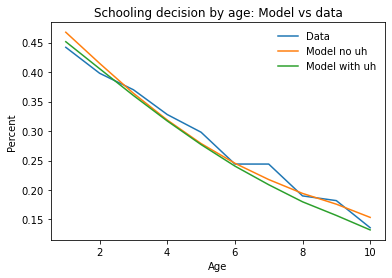

In [337]:
# Schooling

fig, ax = plt.subplots()

ax.plot(table_1_mean['Age'], table_1_mean['School'])
ax.plot(11 - table_1_mean['Age'], pred1['School'])
ax.plot(11-table_1_mean['Age'], pred2['School'])

ax.set_title('Schooling decision by age: Model vs data')
ax.set_xlabel('Age', fontsize = 10)
ax.set_ylabel('Percent', fontsize = 10)


ax.legend(['Data', 'Model no uh', 'Model with uh'], frameon = False)

Comments:
+ Both models perform very similarly here. Predict data quite well

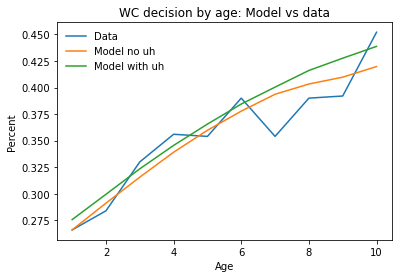

In [336]:
# White collar

fig, ax = plt.subplots()

ax.plot(table_1_mean['Age'], table_1_mean['White_collar'])
ax.plot(11 - table_1_mean['Age'], pred1['WC'])
ax.plot(11-table_1_mean['Age'], pred2['WC'])

ax.set_title('WC decision by age: Model vs data')
ax.set_xlabel('Age', fontsize = 10)
ax.set_ylabel('Percent', fontsize = 10)


ax.legend(['Data', 'Model no uh', 'Model with uh'], frameon = False)

Comments
+ Model with UH predicts more pronounced WC decision increase at higher age. This is probably because managerial type gets more years of education before entering WC jobs because they have more returns to schooling for WC occupations. 

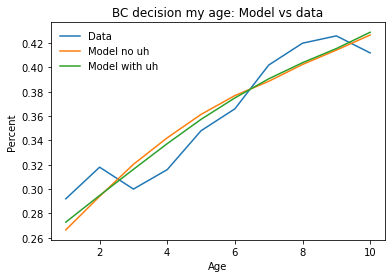

In [339]:
# Blue collar

fig, ax = plt.subplots()

ax.plot(table_1_mean['Age'], table_1_mean['Blue_collar'])
ax.plot(11 - table_1_mean['Age'], pred1['BC'])
ax.plot(11-table_1_mean['Age'], pred2['BC'])

ax.set_title('BC decision my age: Model vs data')
ax.set_xlabel('Age', fontsize = 10)
ax.set_ylabel('Percent', fontsize = 10)


ax.legend(['Data', 'Model no uh', 'Model with uh'], frameon = False)

Comments:
+ Both models perform very similarly
+ Both models fail to predict concave form of BC decision at high ages